<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

# Simulation

In [2]:
# full bc
fbcs = [
  list("GGAGAAGA"),
  list("CCACAATG"),
  list("CCAACCGG"),
  list("CGAAGCCC"),
  list("TCAGTCGA"),
  list("GACCAGCC"),
  list("CTCAAGGT"),
  list("CGCCGCAA"),
  list("ACCAGCCG"),
]
# trim right
rbcs = [
  list("GGAGAAG"),
  list("CCACAAT"),
  list("CCAACCG"),
  list("CGAAGCC"),
  list("TCAGTCG"),
  list("GACCAGC"),
  list("CTCAAGG"),
  list("CGCCGCA"),
  list("ACCAGCC"),
]

# trim left
lbcs = [
  list("GAGAAGA"),
  list("CACAATG"),
  list("CAACCGG"),
  list("GAAGCCC"),
  list("CAGTCGA"),
  list("ACCAGCC"),
  list("TCAAGGT"),
  list("GCCGCAA"),
  list("CCAGCCG"),
]

bcs_names = [
"BC1",
"BC2",
"BC13",
"BC25",
"BC37",
"BC49",
"BC50",
"BC73",
"BC74",
]
bcs_list =[
"GGAGAAGA",
"CCACAATG",
"CCAACCGG",
"CGAAGCCC",
"TCAGTCGA",
"GACCAGCC",
"CTCAAGGT",
"CGCCGCAA",
"ACCAGCCG",
]
bcs = fbcs

# Simulate barcodes with errors and assign them (correct and unambiguous)

In [3]:
# input: barcode of length l
# output: l x 3 matrix with the nucleotide that is not the given nucleotide
def alt(barcode):
  # for each position the set of nucleotides that are not the given on
  d = set(["A", "T", "G", "C"])
  alt = [sorted(list(d.symmetric_difference(i))) for i in barcode]
  return alt

In [6]:
alt("ATCGCGAAA")

[['C', 'G', 'T'],
 ['A', 'C', 'G'],
 ['A', 'G', 'T'],
 ['A', 'C', 'T'],
 ['A', 'G', 'T'],
 ['A', 'C', 'T'],
 ['C', 'G', 'T'],
 ['C', 'G', 'T'],
 ['C', 'G', 'T']]

In [7]:
def mutate(barcode, N, err):
  barcode = list(barcode)
  bc_len = len(barcode)
  mutate_mask = np.random.rand(N,bc_len)<err

  # for each barcode for each base, the other possible nucleotide choices
  replace_opt = np.array(alt(barcode))

  # pick which of the 3 alternative nucleotides to change to
  replace_idx = np.random.choice(3, size=(N, bc_len))

  # select a single column for each row in replace_opt given by replace_idx 
  # do this for all N mutants, for each num_fb
  replace = np.array([replace_opt[np.arange(bc_len), i] for i in replace_idx]) 

  bc_mat = np.tile(barcode, (N, 1))

  # replace the nucleotides where mutate_mask is true
  bc_mat[mutate_mask] = replace[mutate_mask]
  ham = mutate_mask.sum(1)
  return (bc_mat, ham)

In [11]:
mutate("ATCGCGAAA", 10, 0.1)

(array([['A', 'G', 'C', 'A', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'G', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'G', 'C', 'C', 'A', 'G', 'G'],
        ['A', 'T', 'A', 'G', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'G', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'G', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'C', 'C', 'G', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'T', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'G', 'C', 'G', 'A', 'A', 'A'],
        ['A', 'T', 'C', 'G', 'C', 'G', 'C', 'A', 'A']], dtype='<U1'),
 array([2, 0, 3, 1, 0, 0, 1, 1, 0, 1]))

In [12]:
from collections import Counter
def distances(mutants, bcs_mat):
  # for each mutant, determine the set of hamming distances
  ham = []
  for idx, m in enumerate(mutants):    
    d = []
    for tidx, t in enumerate(bcs_mat):
      d.append((t!=m).sum())
    ham.append(d)

  ham = np.array(ham)
  return ham

In [15]:
# TODO: start from here
np.array(bcs)

array([['G', 'G', 'A', 'G', 'A', 'A', 'G', 'A'],
       ['C', 'C', 'A', 'C', 'A', 'A', 'T', 'G'],
       ['C', 'C', 'A', 'A', 'C', 'C', 'G', 'G'],
       ['C', 'G', 'A', 'A', 'G', 'C', 'C', 'C'],
       ['T', 'C', 'A', 'G', 'T', 'C', 'G', 'A'],
       ['G', 'A', 'C', 'C', 'A', 'G', 'C', 'C'],
       ['C', 'T', 'C', 'A', 'A', 'G', 'G', 'T'],
       ['C', 'G', 'C', 'C', 'G', 'C', 'A', 'A'],
       ['A', 'C', 'C', 'A', 'G', 'C', 'C', 'G']], dtype='<U1')

In [ ]:
# Functions
# function, given a barcode, N, and error, return a list of mutants


def main(bcs, bc_len, N, max_ham_dist, err):
  mutants = []
  dist = []
  
  for bc in bcs:
    m, d = mutate(bc, N, err)
    mutants.append(m)
    dist.append(d)
  
  dist = np.concatenate(dist, 0)
  bcs_mat = np.array(bcs)
  mutants = np.concatenate(mutants, 0)
  mutant_origin = np.repeat(labels, N)
  total_dists = Counter(dist)
  ham = distances(mutants, bcs_mat)

  # Perform the assignment
  # [ min , max)
  # We want the maximum hamming after which it is ambiguous
  assign = []
  for h in ham:
    c = Counter(h)

    du = np.array([*c.keys()])
    du_argsort = np.argsort(du)

    one_idx, two_idx, *_ = du_argsort
    one_ham, two_ham = du[one_idx], du[two_idx]

    one_mul, two_mul = c[one_ham], c[two_ham]
    if one_mul == 1:
      min_ham = one_ham
      max_ham = two_ham 
      target = np.where(h == one_ham)[0][0]
    elif one_mul > 1:
      min_ham = one_ham - 1
      max_ham = one_ham
      target = -1

    assign.append([target, min_ham,  max_ham])
  
  assign = np.array(assign)
  correct = np.equal(assign[:,0], mutant_origin)
  ambiguous = np.equal(assign[:,0], -1)
  
  mask = np.logical_and(correct, ~ambiguous)
  data = Counter(np.array(assign)[:,1][mask])
  N_sim = []
  N_gen = []
  for i in np.arange(max_ham_dist):
    N_gen.append(total_dists.get(i))
    N_sim.append(data.get(i))
  return (N_gen, N_sim)



In [ ]:
N = 20_000
bc_len = 8
max_ham = 7
n_bcs = len(bcs)
labels = np.arange(n_bcs)
np.random.seed(0)


In [ ]:
err = np.linspace(0.001, 0.15, 10)

In [ ]:
err

array([0.001     , 0.01755556, 0.03411111, 0.05066667, 0.06722222,
       0.08377778, 0.10033333, 0.11688889, 0.13344444, 0.15      ])

In [ ]:
%%time
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(bcs, bc_len, N, max_ham, e)
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim)
gen = np.array(gen)
gen[np.where(gen==None)] = np.nan
sim[np.where(sim==None)] = 0

data = (sim/gen).astype(float)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 1min 58s, sys: 5.13 s, total: 2min 3s
Wall time: 1min 58s


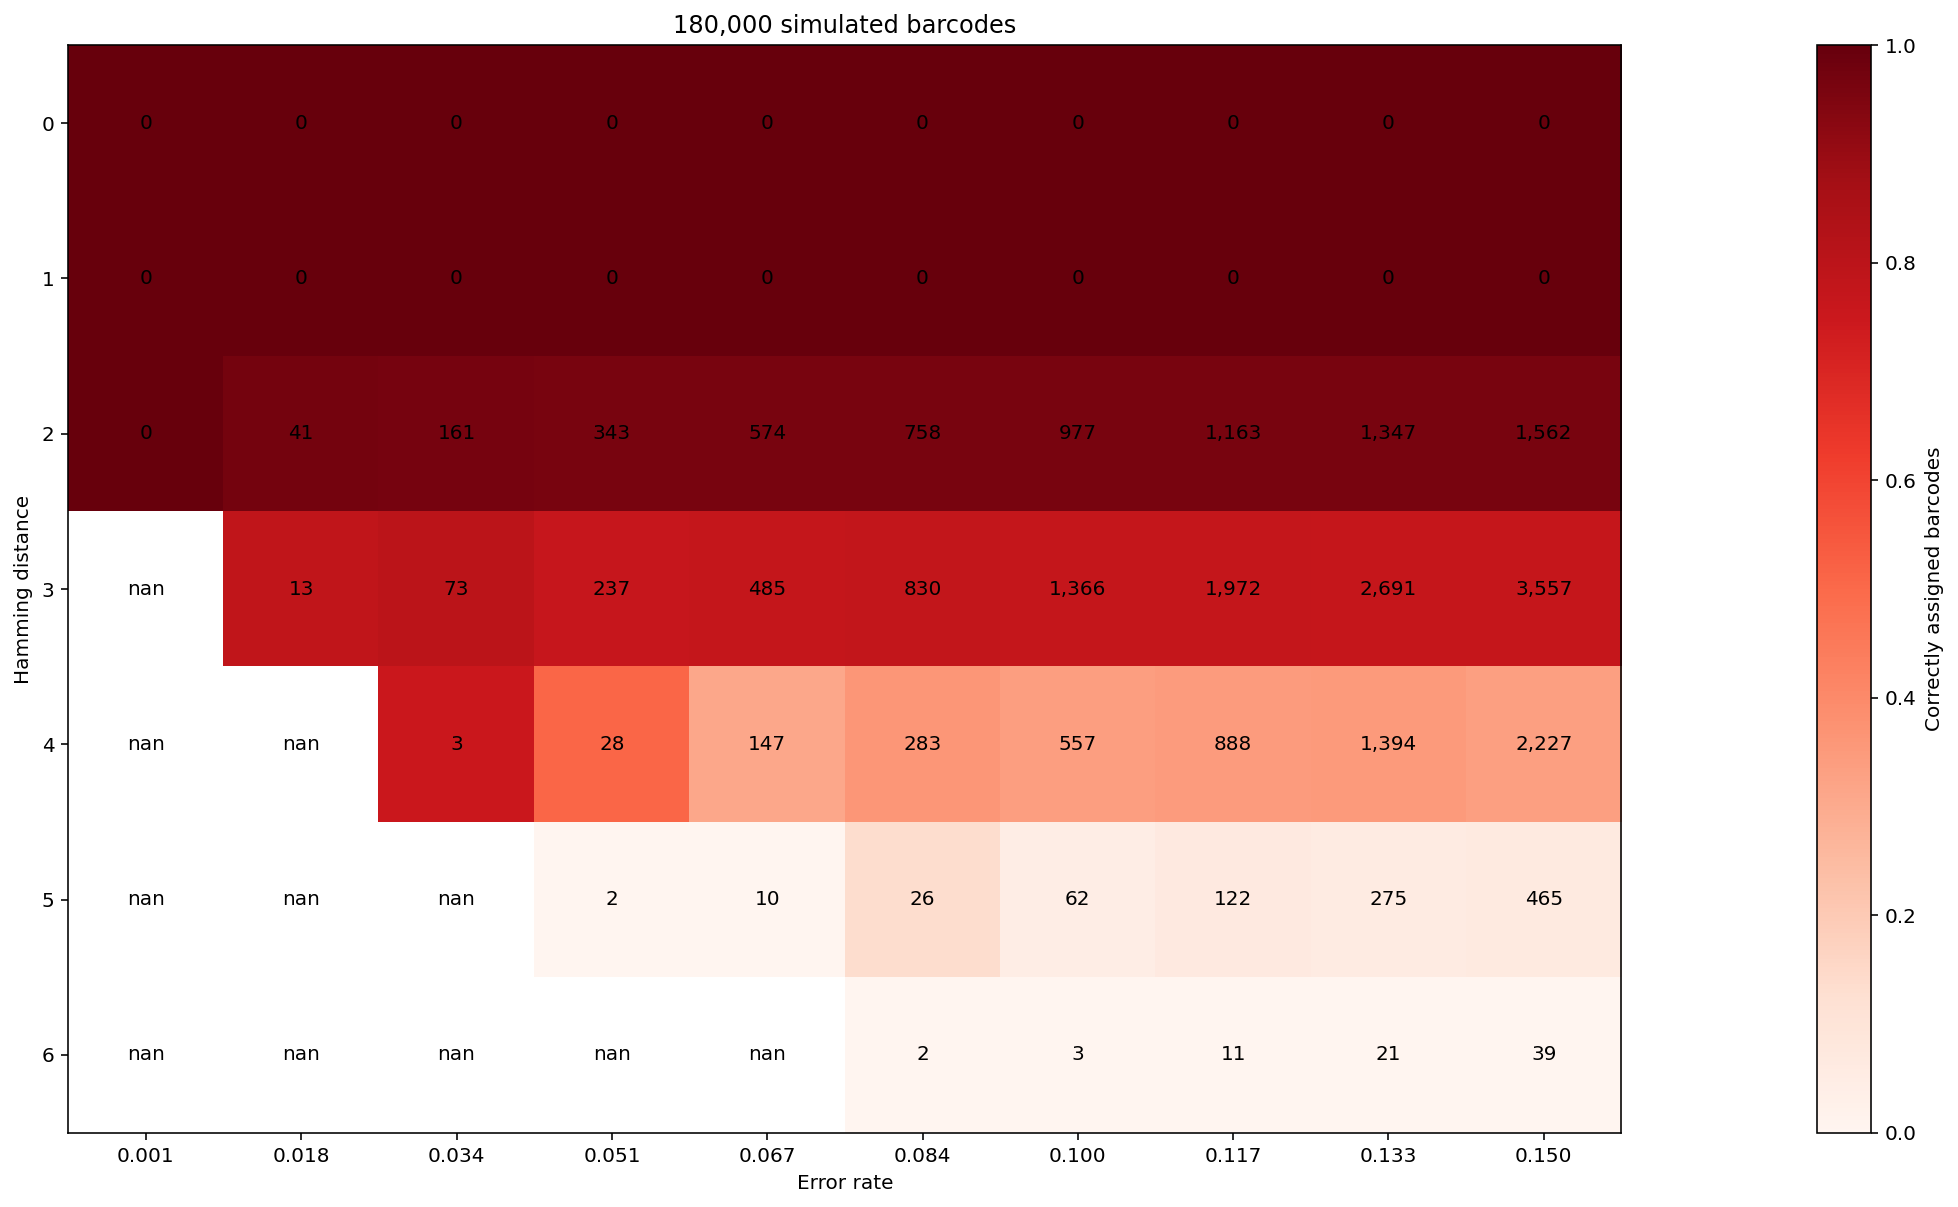

In [ ]:
fig, ax = plt.subplots(figsize=(35,10))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, label="Correctly assigned barcodes")
errors = [f"{i:,.3f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance",
    "title": f"{N*n_bcs:,.0f} simulated barcodes"
})

for (j,i),label in np.ndenumerate(data.T):
  lost = gen[i,j] - sim[i,j]
  string = f"{lost:,.0f}"
  ax.text(i,j,string,ha='center',va='center')

fig.show()

In [ ]:
f"{lost:,}"

'39'

In [ ]:
# generate random list of barcodes and compare
def gen_random(N, bc_len):
  nuc_opts = np.tile(["A","T","G","C"], (N,bc_len,1))
  replace_idx = np.random.choice(4, size=(N, bc_len))
  replace = np.array([nuc_opts[idx][np.arange(bc_len), i] for idx, i in enumerate(replace_idx)]) 
  return replace

In [ ]:
random_barcodes = gen_random(n_bcs, bc_len)

In [ ]:
random_barcodes

array([['C', 'T', 'G', 'C', 'G', 'A', 'G', 'G'],
       ['G', 'T', 'C', 'C', 'T', 'G', 'T', 'C'],
       ['T', 'C', 'A', 'C', 'T', 'A', 'C', 'T'],
       ['T', 'G', 'A', 'A', 'A', 'T', 'G', 'C'],
       ['C', 'C', 'C', 'A', 'C', 'T', 'A', 'A'],
       ['G', 'G', 'T', 'A', 'G', 'G', 'T', 'G'],
       ['C', 'C', 'A', 'A', 'C', 'G', 'C', 'G'],
       ['A', 'A', 'G', 'T', 'T', 'C', 'A', 'C'],
       ['G', 'C', 'A', 'C', 'C', 'A', 'G', 'T']], dtype='<U1')

In [ ]:
%%time
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(random_barcodes, bc_len, N, max_ham, e)
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim)
gen = np.array(gen)
gen[np.where(gen==None)] = np.nan
sim[np.where(sim==None)] = 0

data = (sim/gen).astype(float)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 1min 58s, sys: 4.79 s, total: 2min 2s
Wall time: 1min 58s


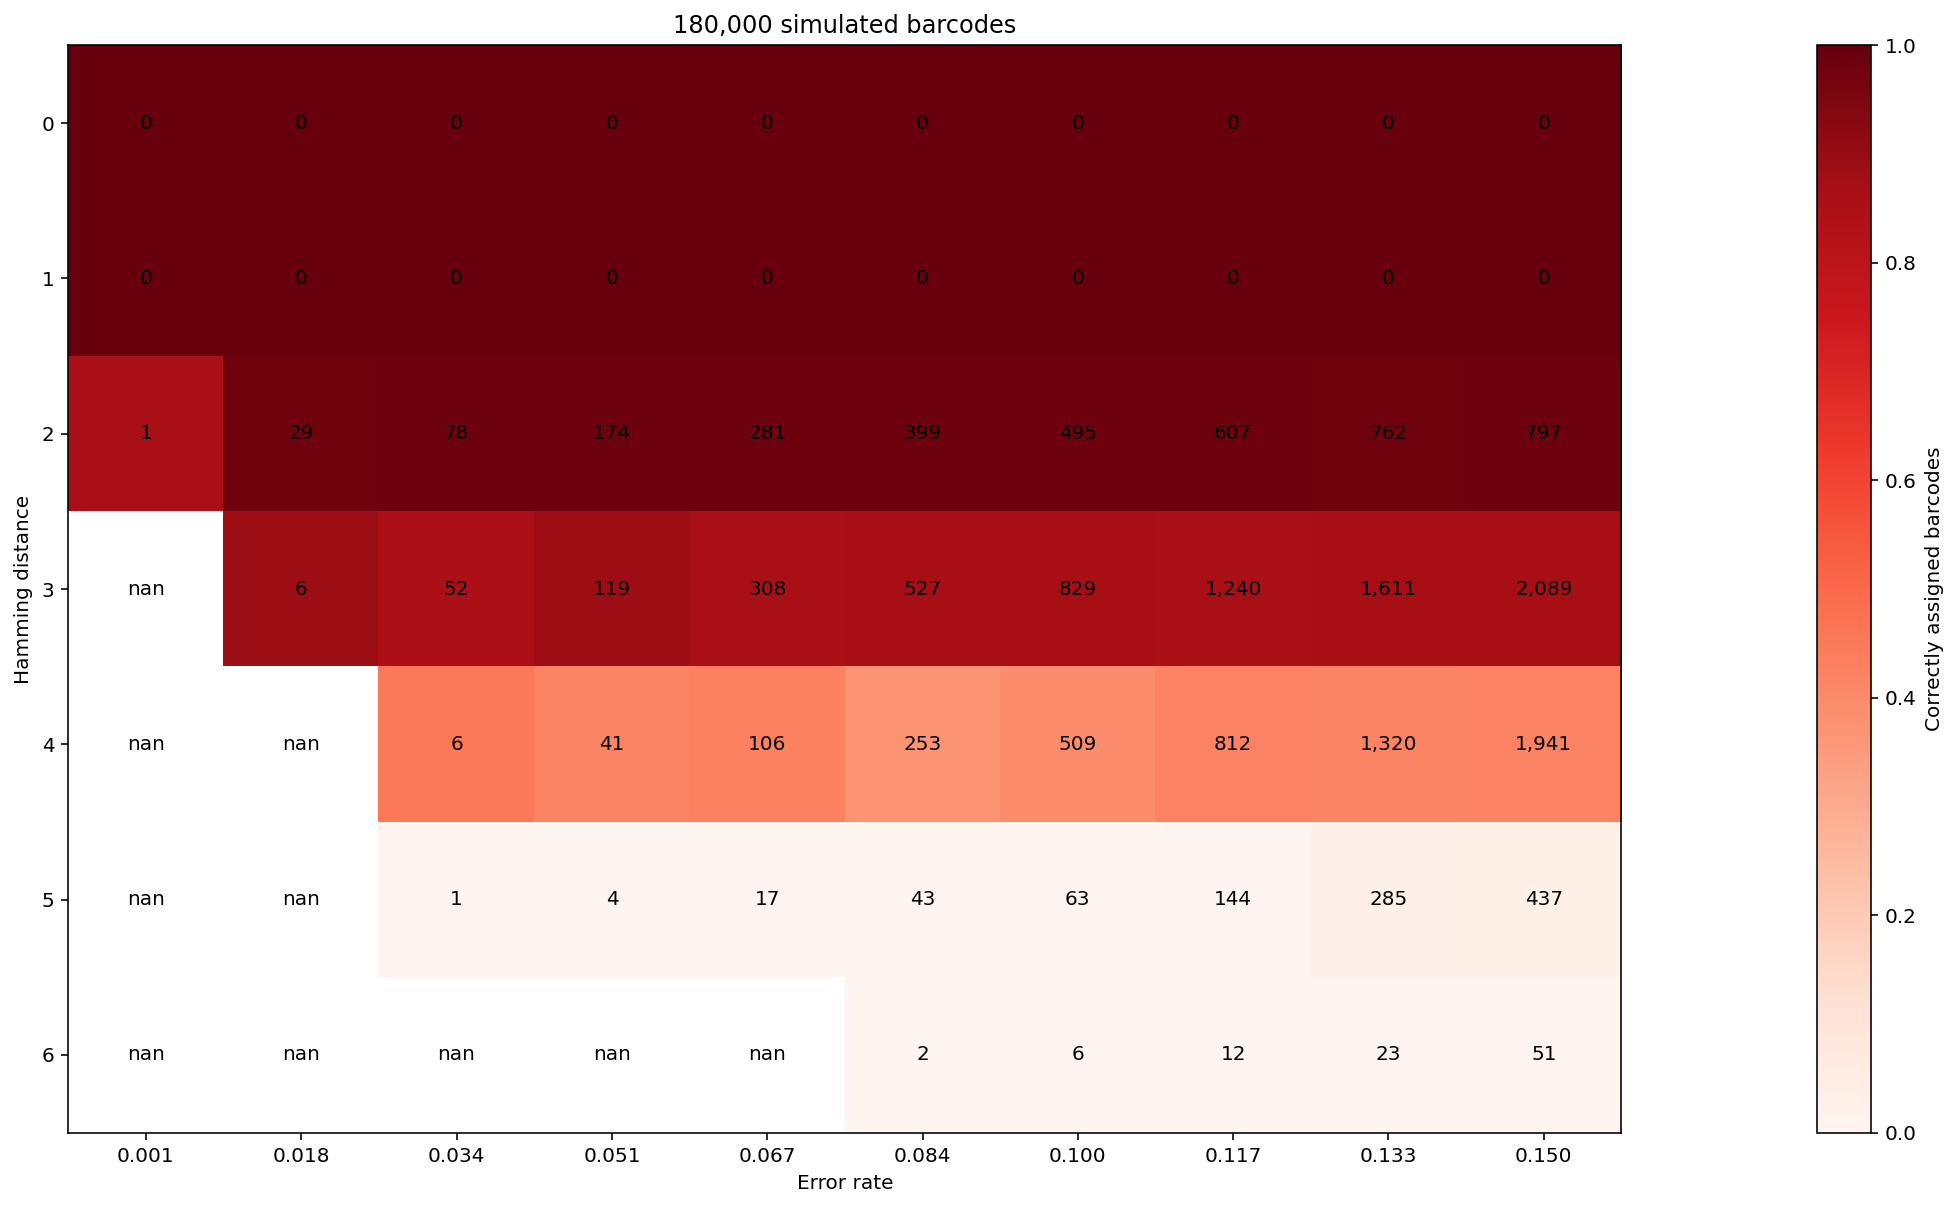

In [ ]:
fig, ax = plt.subplots(figsize=(35,10))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, label="Correctly assigned barcodes")
errors = [f"{i:,.3f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance",
    "title": f"{N*n_bcs:,.0f} simulated barcodes"
})

for (j,i),label in np.ndenumerate(data.T):
  lost = gen[i,j] - sim[i,j]
  string = f"{lost:,.0f}"
  ax.text(i,j,string,ha='center',va='center')

fig.show()

# All together

In [ ]:
%%time

# Given bcs
sim = []
gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(bcs, bc_len, N, max_ham, e)
  sim.append(N_sim)
  gen.append(N_gen)

sim = np.array(sim)
gen = np.array(gen)
gen[np.where(gen==None)] = np.nan
sim[np.where(sim==None)] = 0

data = (sim/gen).astype(float)

# Random bcs
random_barcodes = gen_random(n_bcs, bc_len)

r_sim = []
r_gen= []
for idx, e in enumerate(err):
  print(f"{idx + 1} of {len(err)}")
  N_gen, N_sim = main(random_barcodes, bc_len, N, max_ham, e)
  r_sim.append(N_sim)
  r_gen.append(N_gen)

r_sim = np.array(r_sim)
r_gen = np.array(r_gen)
r_gen[np.where(r_gen==None)] = np.nan
r_sim[np.where(r_sim==None)] = 0

r_data = (r_sim/r_gen).astype(float)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10
CPU times: user 3min 56s, sys: 9.2 s, total: 4min 5s
Wall time: 3min 55s


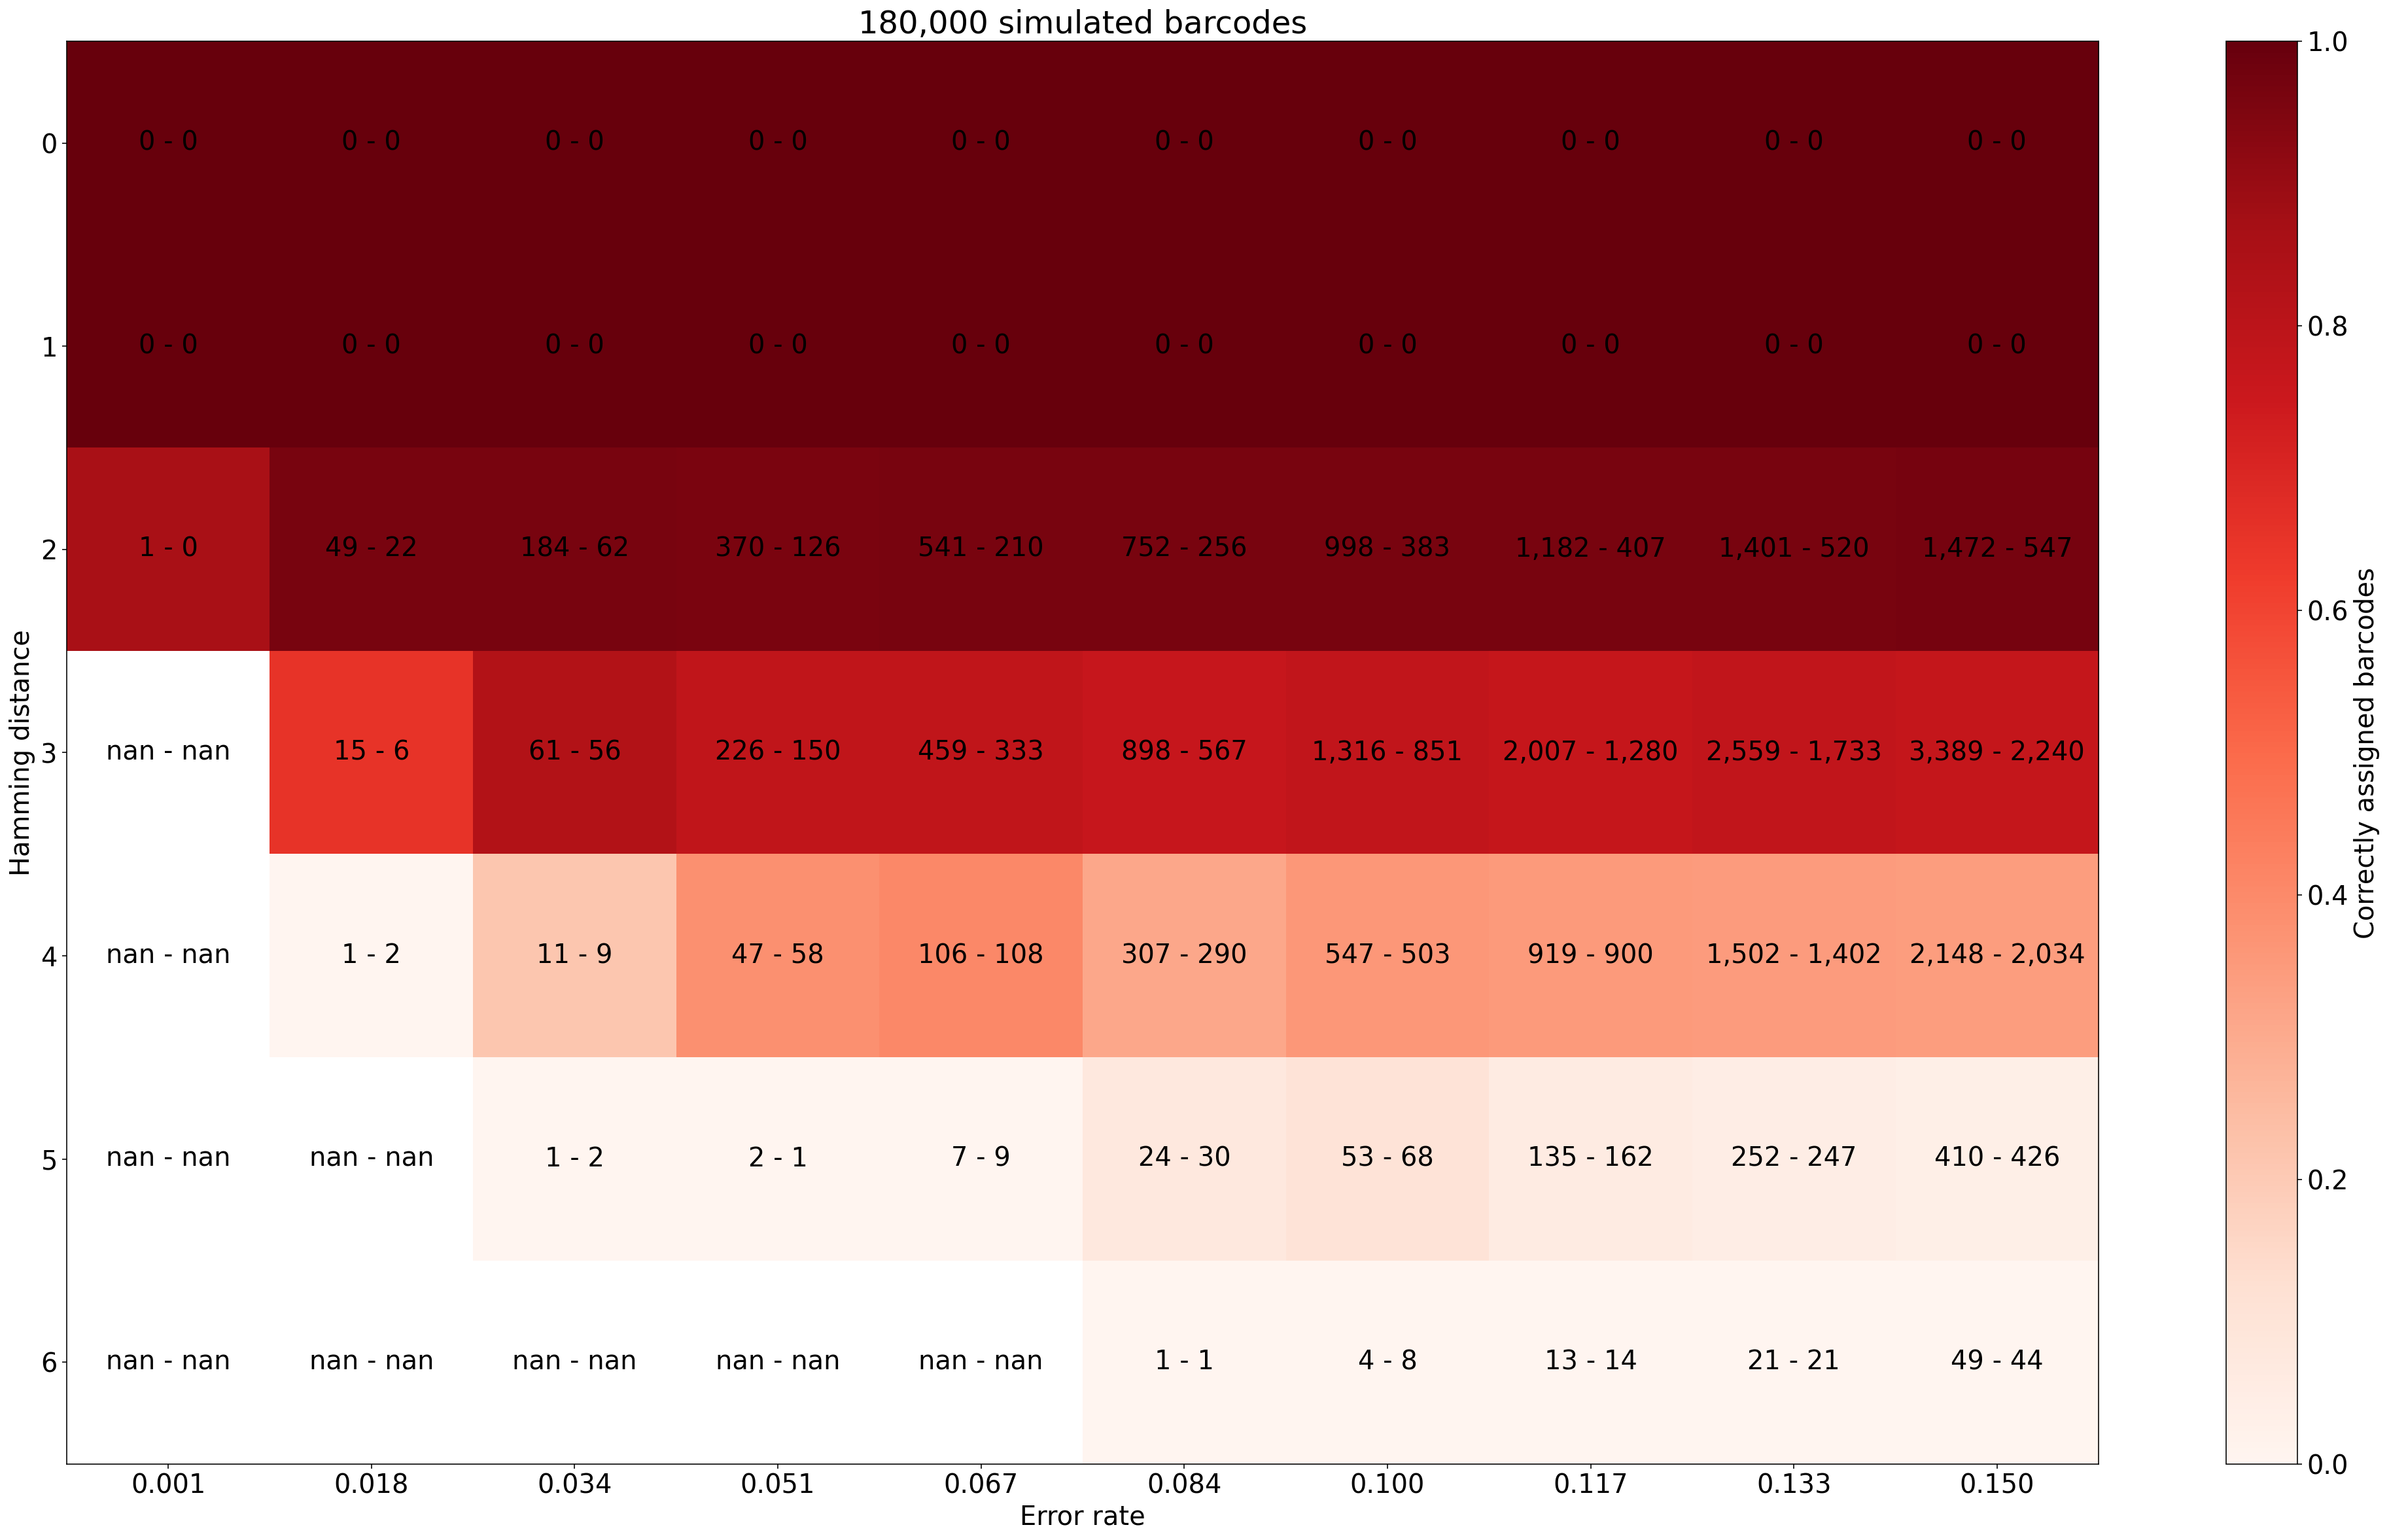

In [ ]:
fig, ax = plt.subplots(figsize=(35,20))

im = ax.imshow(data.T, cmap="Reds")
fig.colorbar(im, label="Correctly assigned barcodes")
errors = [f"{i:,.3f}" for i in err]
ax.set(**{
    "xticklabels": errors,
    "xticks": np.arange(len(errors)),
    "xlabel": "Error rate",
    "ylabel": "Hamming distance",
    "title": f"{N*n_bcs:,.0f} simulated barcodes"
})

for (j,i),label in np.ndenumerate(data.T):
  lost = gen[i,j] - sim[i,j]
  r_lost = r_gen[i,j] - r_sim[i,j]
  string = f"{lost:,.0f} - {r_lost:,.0f}"
  ax.text(i,j,string,ha='center',va='center')
fig.savefig("sim_cmp.png")
fig.show()